- dataset of 99 cats and 1 boat
- very unbalanced, model doesn't learn. It is learning bias b/c we can just tell it to guess cat every time and it will have 99% accuracy

##working with unbalanced data
- disease images, credit card transactions - are usually unbalanced
- ideally datasets are balanced (near perfect 50/50 split)
- the more data available means the the less necessary a perfect split is
- computing accuarcy per category is a good practice


##Challenge Outline
- leaky relu activation functin
- adam optimizer
- learning rate of 0.001
- 500 epochs
- create a function that exports the train/test dataloaders with a specified quality threshold for bianarized good/bad wine
- train the model with different thresholds of 4.5,5.5,6.5 and plot the results ( this will force unbalance in the data set for good and bad wine)

- plot a 3x3 figure
- each row is the threshold value
- plot loss, accuracy, test accuracy per class

In [190]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
def createModel():
    # create a class for the model

  class ANNwine(nn.Module):
    def __init__(self,actfun="LeakyReLU"):
      super().__init__()

      ### input layer
      self.input = nn.Linear(11,32)

      ### hidden layers
      self.fc1 = nn.Linear(32,32)
      self.fc2 = nn.Linear(32,32)


      ### output layer
      self.output = nn.Linear(32,1)

      # activation funcion to pass through
      self.actfun = actfun

    # forward pass
    def forward(self,x):
      # get activation function type
      # this code replaces torch.relu with torch.<self.actfun>
      actfun = getattr(torch.nn,self.actfun)
      x = actfun()( self.input(x) )
      x = actfun()( self.fc1(x) )
      x = actfun()( self.fc2(x) )
      return self.output(x)

  net = ANNwine()
  loss = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr =0.001)
  return net, loss, optimizer

In [192]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel(train_loader, test_loader):

  # loss function and optimizer
  model, lossfun, optimizer = createModel()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses, model

In [193]:
def create_loaders(data, quali):
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
  data = pd.read_csv(url,sep=';')
  data = data[data['total sulfur dioxide']<200] # drop a few outliers

  # z-score all columns except for quality
  cols2zscore = data.keys()
  cols2zscore = cols2zscore.drop('quality')
  data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
  tmp = (data['quality']>quali ).astype(int)
  data['boolQuality'] = tmp
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None]
  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = torch.utils.data.TensorDataset(train_data,train_labels)
  test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize    = 64
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
  return train_loader, test_loader

In [194]:
def get_class_accuracy(test_loader, model):
  total_per_class = torch.zeros(2)
  correct_per_class = torch.zeros(2)
  for X,y in test_loader:
    yHat = model(X)
    yHat = (yHat > 0.0).float()

    for i in range(len(y)):
      label = y[i].item()
      pred = yHat[i].item()
      total_per_class[int(label)] += 1
      if label == pred:
        correct_per_class[int(label)] +=1

  class_accuracy = correct_per_class / total_per_class

  return class_accuracy

In [195]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

##Single Test

In [196]:
train_loader, test_loader = create_loaders(data ,5)
trainAcc, testAcc, losses, model = trainTheModel(train_loader, test_loader)

In [197]:
class_accuracy = get_class_accuracy(test_loader, model)
class_accuracy

tensor([0.7258, 0.7551])

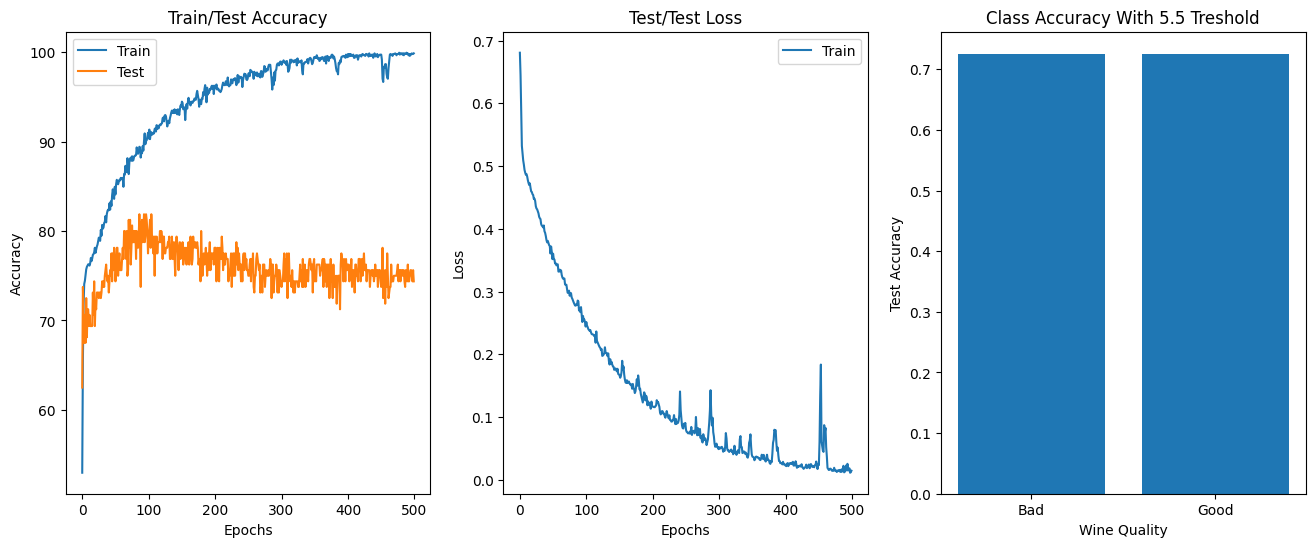

In [198]:
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].plot(range(numepochs), trainAcc,markerfacecolor='w',markersize=9)
ax[0].plot(range(numepochs), testAcc,markerfacecolor='r',markersize=9)
# ax[0].plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax[0].plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax[0].legend(['Train', "Test"])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train/Test Accuracy')

ax[1].plot(range(numepochs), losses,markerfacecolor='w',markersize=9)
ax[1].legend(['Train', "Test"])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Test/Test Loss')

ax[2].bar(['Bad', 'Good'], class_accuracy[0])
ax[2].set_ylabel('Test Accuracy')
ax[2].set_xlabel('Wine Quality')
ax[2].set_title('Class Accuracy With 5.5 Treshold')
plt.show()

#Experiment

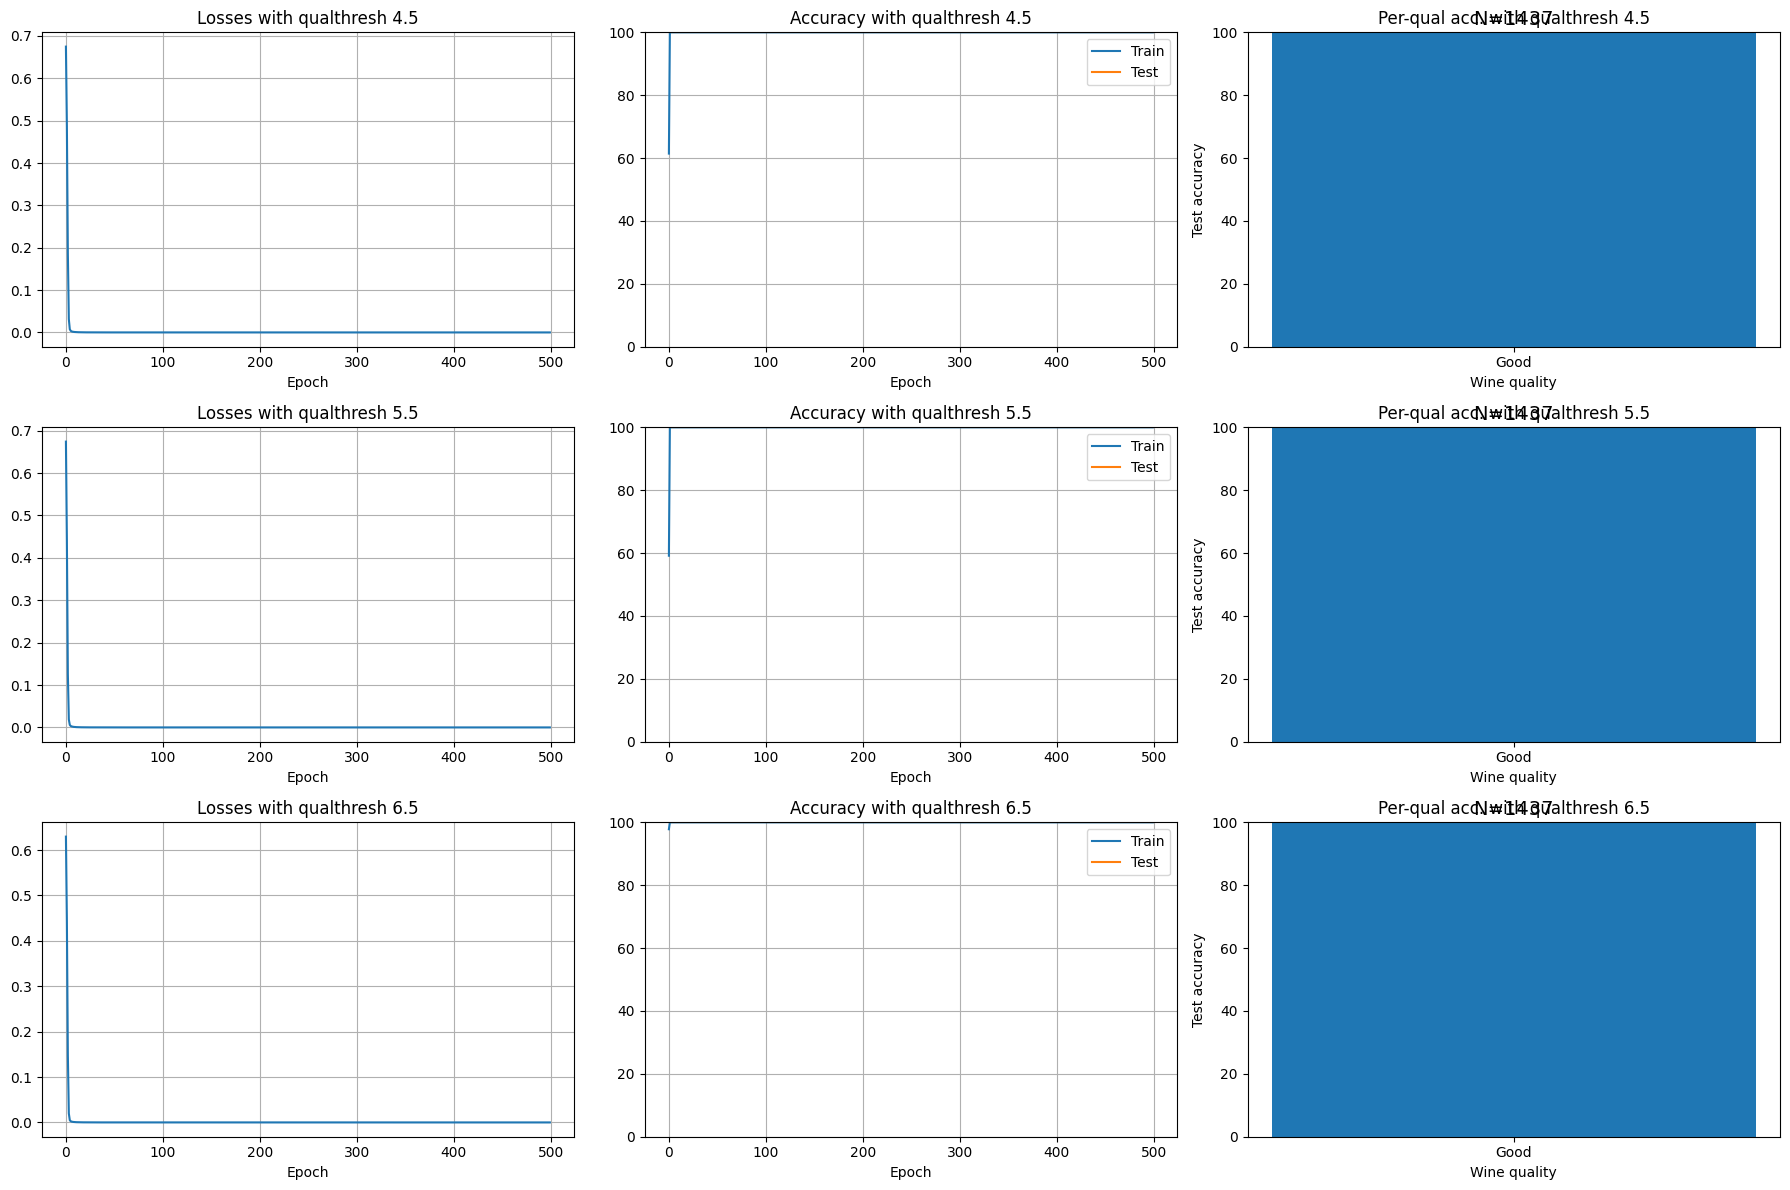

In [199]:
# note: this cell takes around 5 mins

# setup the figure
fig,ax = plt.subplots(3,3,figsize=(18,12))

# the quality thresholds
qualityThresholds = [4,5,6]


# loop over quality thresholds
for quali in range(len(qualityThresholds)):

  # create the data and model, and train it
  train_loader,test_loader = create_loaders( data, quali )
  trainAcc,testAcc,losses, winenet = trainTheModel(train_loader, test_loader)

  # compute accuracy per quality type
  X,y = next(iter(test_loader))
  itemAccuracy = ((winenet(X)>0) == y).float()
  perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                  100*torch.mean(itemAccuracy[y==1]) ]


  # plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epoch')
  ax[quali,0].grid()

  # plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,1].legend()
  ax[quali,1].set_xlabel('Epoch')
  ax[quali,1].set_ylim([0,100])
  ax[quali,1].grid()

  # plot the per-quality accuracy
  bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
  ax[quali,2].set_ylim([0,100])
  ax[quali,2].set_xlabel('Wine quality')
  ax[quali,2].set_ylabel('Test accuracy')
  ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()

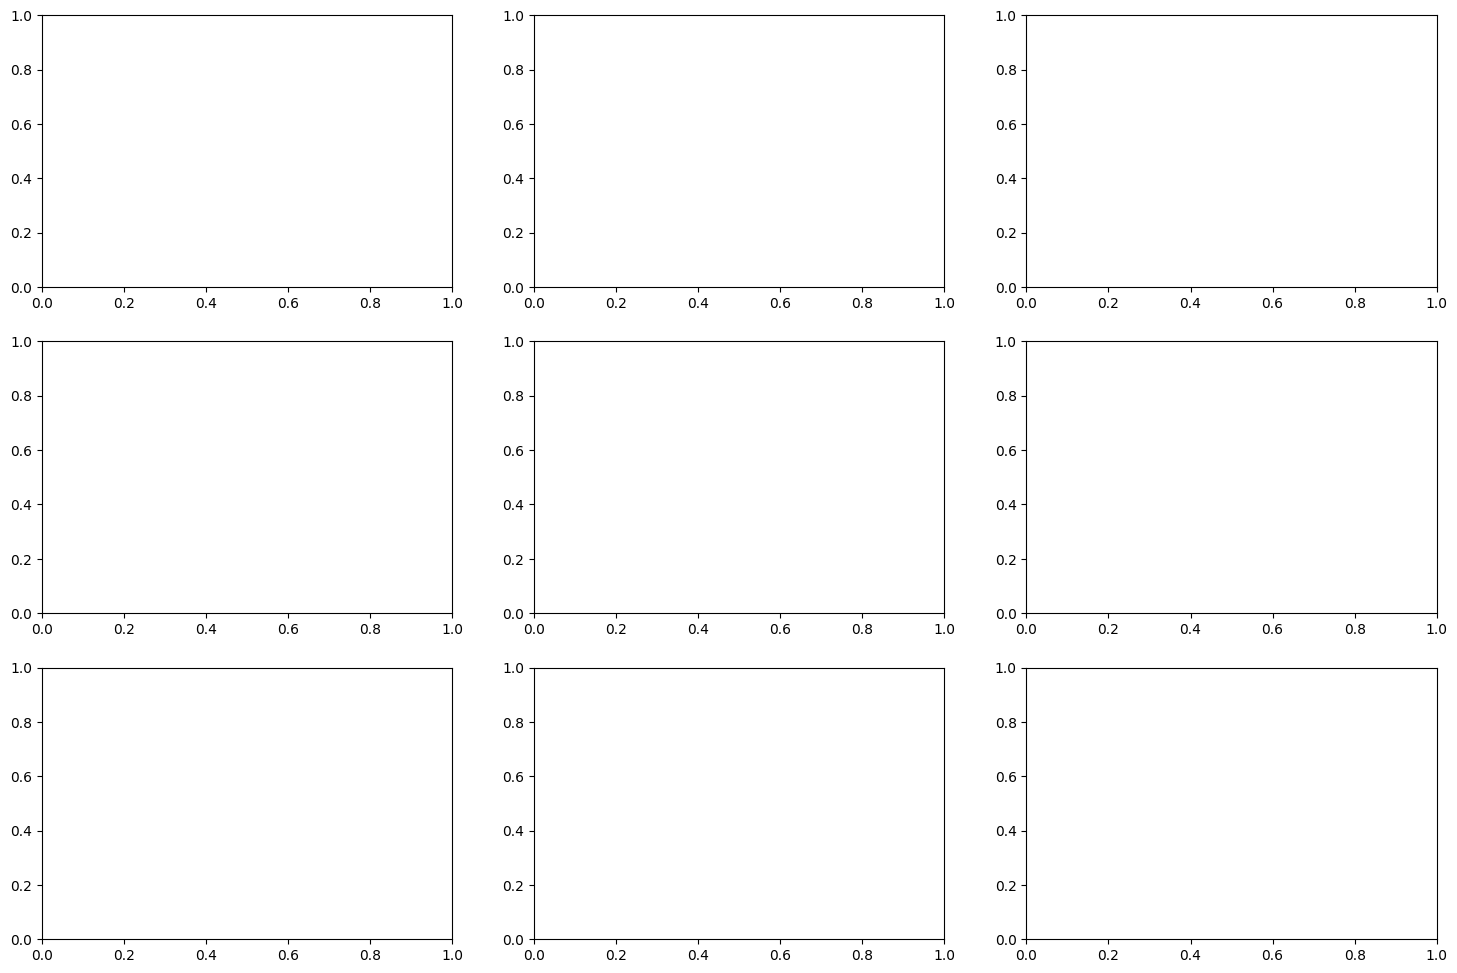

In [200]:
fig,ax = plt.subplots(3,3,figsize=(18,12))
